In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys

sys.path.insert(0, '../')

In [2]:
import imports as im
import functions as fn
%matplotlib inline

In [3]:
# Set path to directory with folders

# path_train_audio = '../data/data/train_wav/' # kaggle data with .wav files
path_train_audio = '../audios/' # kaggle data with .wav files
# path_train_audio = '../article_data/full_clips_all/' # article data

path_target_train = '../data/train.csv' # kaggle file with labels
# path_target_train = '../article_data/annotations_full.csv' # article file with labels

# path_train_img = '../data/data/train_img/' # images directory path for kaggle data, where images will be stored
path_train_img = '../datasets/pngs_from_wavs/' # images directory path for kaggle data, where images will be stored
# path_train_img = '../article_data/data_images/' # images directory path for article data

Create spectrogram images

In [4]:
# It takes about 15-20 minutes
# fn.create_images_data(path_train_audio, path_train_img, width=180, height=190)

In [5]:
# It takes about 15-20 minutes
spectrograms_folder = '../spectrograms/'
# fn.create_new_images(path_train_audio, spectrograms_folder)

In [7]:
# Create dataset with augmentation images. It takes about 2-3 minutes
combined_dataset = fn.CreateKaggleDatasetNew(csv_file=path_target_train, image_folder=spectrograms_folder)

In [7]:
# Get the first example from the dataset
# for image, label in combined_dataset.take(1):
#     # Convert the TensorFlow tensor to a NumPy array
#     image = image.numpy()
#     print(image.shape)
    
#     # Plot the image
#     im.plt.imshow(image)
#     im.plt.title(f"Label: {label}")
#     im.plt.axis('off')  # Turn off axis labels
#     im.plt.show()

In [8]:
combined_dataset = combined_dataset.shuffle(1024*2, seed=42)

In [9]:
# Define the sizes for train, validation, and test sets
train_size = int(0.9 * len(combined_dataset))  # 90% for training
val_size = int(0.05 * len(combined_dataset))   # 5% for validation
test_size = len(combined_dataset) - train_size - val_size  # Remaining for testing

# Shuffle the dataset before splitting
combined_dataset = combined_dataset.shuffle(len(combined_dataset))

# Split the dataset
train_dataset = combined_dataset.take(train_size)
temp_dataset = combined_dataset.skip(train_size)
val_dataset = temp_dataset.take(val_size)
test_dataset = temp_dataset.skip(val_size)

# Define batch size
batch_size = 64

# Batch and preprocess the datasets
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()  # The training dataset must repeat for several epochs
train_dataset = train_dataset.prefetch(im.tf.data.experimental.AUTOTUNE)  # Prefetch next batch while training

val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(im.tf.data.experimental.AUTOTUNE)

test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(im.tf.data.experimental.AUTOTUNE)


Create datasets

- train : 90%
- val : 5%
- test : 5%

In [4]:
# Link for NN model Xception
im.ssl._create_default_https_context = im.ssl._create_unverified_context

### Xception Network

In [5]:
# https://keras.io/guides/transfer_learning/

Xception_model = im.keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(255, 255, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [6]:
# Freeze the base_model
Xception_model.trainable = False

In [7]:
inputs = im.keras.Input(shape=(255, 255, 3))
x = inputs
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`.

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = im.keras.layers.Rescaling(scale=2.0, offset=-1)
x = scale_layer(x)

In [8]:
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = Xception_model(x, training=False)
x = im.keras.layers.GlobalAveragePooling2D()(x)
x = im.keras.layers.Dense(100, activation= 'relu')(x)
x = im.keras.layers.Dropout(0.1)(x)
outputs = im.keras.layers.Dense(1, activation= 'sigmoid')(x)
xception = im.keras.Model(inputs, outputs)

xception.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 255, 255, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 255, 255, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                             

In [9]:
# weights_file_layers = '../weights_xception/xception_weights_layers.h5'
# xception.load_weights(weights_file_layers)

callback_layers = [
    # im.ModelCheckpoint(
    #     weights_file_layers, mode='max', save_best_only=True
    #     ),
    im.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.7, patience=3, mode='min', min_lr=0
    ),
]

xception.compile(
    optimizer=im.tf.keras.optimizers.legacy.Adam(),
    loss=im.keras.losses.BinaryCrossentropy(),
    metrics=[im.keras.metrics.BinaryAccuracy(), im.tf.keras.metrics.Recall(), im.tf.keras.metrics.Precision()],
)

In [18]:
epochs = 20
# Training epochs definition 
steps_per_epoch = train_size // batch_size

HistoryTop = xception.fit(train_dataset, epochs=epochs, validation_data=val_dataset, steps_per_epoch=steps_per_epoch, callbacks=[callback_layers])

Epoch 1/20
520/520 [==============================] - 959s 2s/step - loss: 0.3086 - binary_accuracy: 0.8564 - recall: 0.7453 - precision: 0.7858 - val_loss: 0.0739 - val_binary_accuracy: 0.9803 - val_recall: 0.9922 - val_precision: 0.9875 - lr: 0.0010
Epoch 2/20
520/520 [==============================] - 894s 2s/step - loss: 0.2755 - binary_accuracy: 0.8742 - recall: 0.7862 - precision: 0.8079 - val_loss: 0.0650 - val_binary_accuracy: 0.9824 - val_recall: 0.9981 - val_precision: 0.9841 - lr: 0.0010
Epoch 3/20
520/520 [==============================] - 895s 2s/step - loss: 0.2615 - binary_accuracy: 0.8827 - recall: 0.8073 - precision: 0.8156 - val_loss: 0.0627 - val_binary_accuracy: 0.9822 - val_recall: 0.9944 - val_precision: 0.9873 - lr: 0.0010
Epoch 4/20
520/520 [==============================] - 900s 2s/step - loss: 0.2499 - binary_accuracy: 0.8884 - recall: 0.8134 - precision: 0.8269 - val_loss: 0.0625 - val_binary_accuracy: 0.9841 - val_recall: 0.9972 - val_precision: 0.9864 - lr:

In [10]:
weights_file_finetun = '../weights_xception/xception_weights_finetun.h5'
callback_finetun = [
    im.ModelCheckpoint(
        weights_file_finetun, mode='max', save_weights_only=True, save_best_only=True, monitor='val_accuracy'
        ),
    im.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.75, patience=3, mode='min', min_lr=0
    ),
]
# xception.load_weights(weights_file_finetun)

# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
Xception_model.trainable = True

xception.summary()
 
xception.compile(
    optimizer=im.tf.keras.optimizers.legacy.Adam(1e-5),  # Low learning rate
    loss=im.keras.losses.BinaryCrossentropy(),
    metrics=[im.keras.metrics.BinaryAccuracy(), im.tf.keras.metrics.Recall(), im.tf.keras.metrics.Precision()],
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 255, 255, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 255, 255, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                             

In [23]:
epochs = 8
HistoryFinetun = xception.fit(train_dataset, epochs=epochs, validation_data=val_dataset, steps_per_epoch=steps_per_epoch, callbacks=[callback_finetun])

Epoch 1/8
520/520 [==============================] - ETA: 0s - loss: 0.1729 - binary_accuracy: 0.9259 - recall_1: 0.8929 - precision_1: 0.8735

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


520/520 [==============================] - 4348s 8s/step - loss: 0.1729 - binary_accuracy: 0.9259 - recall_1: 0.8929 - precision_1: 0.8735 - val_loss: 0.0396 - val_binary_accuracy: 0.9900 - val_recall_1: 0.9983 - val_precision_1: 0.9914 - lr: 1.0000e-05
Epoch 2/8
520/520 [==============================] - 4377s 8s/step - loss: 0.1314 - binary_accuracy: 0.9438 - recall_1: 0.9217 - precision_1: 0.9008 - val_loss: 0.0179 - val_binary_accuracy: 0.9970 - val_recall_1: 0.9992 - val_precision_1: 0.9978 - lr: 1.0000e-05
Epoch 3/8
520/520 [==============================] - 4430s 9s/step - loss: 0.1075 - binary_accuracy: 0.9547 - recall_1: 0.9359 - precision_1: 0.9205 - val_loss: 0.0182 - val_binary_accuracy: 0.9943 - val_recall_1: 0.9994 - val_precision_1: 0.9947 - lr: 1.0000e-05
Epoch 4/8
520/520 [==============================] - 4424s 9s/step - loss: 0.0834 - binary_accuracy: 0.9660 - recall_1: 0.9521 - precision_1: 0.9399 - val_loss: 0.0181 - val_binary_accuracy: 0.9968 - val_recall_1: 0.99

In [1]:
import pickle

with open('HistoryFinetun', 'rb') as file:
    HistoryFinetun = pickle.load(file)


In [25]:
# with open('HistoryFinetun', 'wb') as file_pi:
#     pickle.dump(HistoryFinetun.history, file_pi)

If we want to use model with trained weights

In [11]:
weights_file = '../weights_xception/xception_weights_finetun.h5'
xception.load_weights(weights_file)
xception.trainable = False

In [6]:
LossTop = HistoryTop.history['recall']
ValLossTop = HistoryTop.history['val_recall']

AccTop = HistoryTop.history['precision']
ValAccTop = HistoryTop.history['val_precision']

EpochsTop = range(1, len(LossTop) + 1)

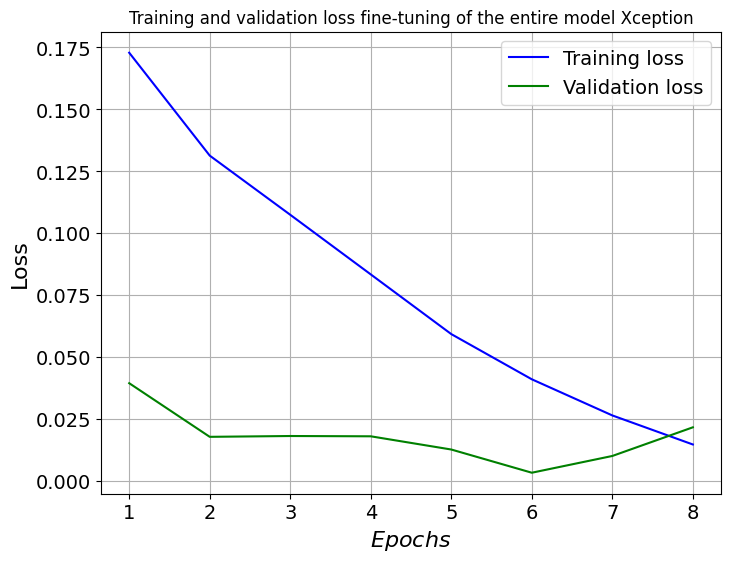

In [11]:
fn.PlotLossAcc(TrainData=LossTop, ValData=ValLossTop, Epochs=EpochsTop,
            TrainLabel='Training recall', ValLabel='Validation recall',
            yLabel='Recall', title='Training and validation recall the top layer Xception',
            ColTrain='blue', ColVal='green', filename="../images/recall_top.pdf")

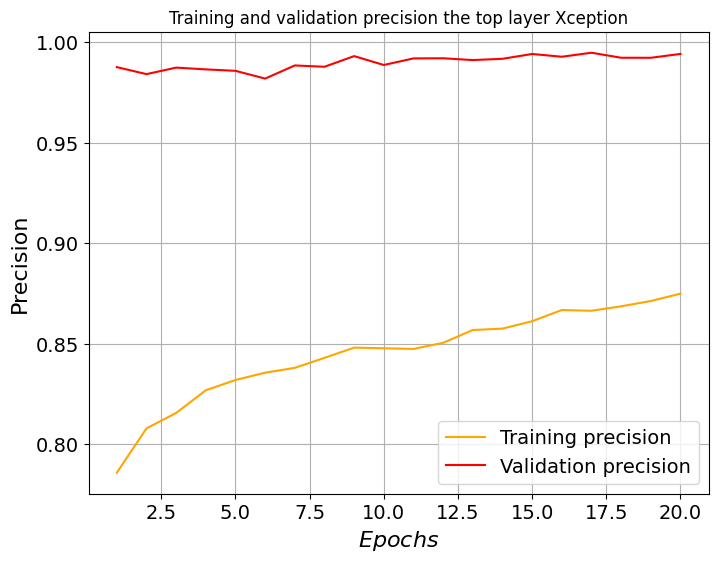

In [42]:
fn.PlotLossAcc(TrainData=AccTop, ValData=ValAccTop, Epochs=EpochsTop,
            TrainLabel='Training precision', ValLabel='Validation precision',
            yLabel='Precision', title='Training and validation precision the top layer Xception',
            ColTrain='orange', ColVal='red', filename="../images/precision_top.pdf")

In [2]:
LossFine = HistoryFinetun['loss']
ValLossFine = HistoryFinetun['val_loss']

AccFine = HistoryFinetun.history['precision_1']
VallAccFine = HistoryFinetun.history['val_precision_1']

EpochsFine = range(1, len(LossFine) + 1)

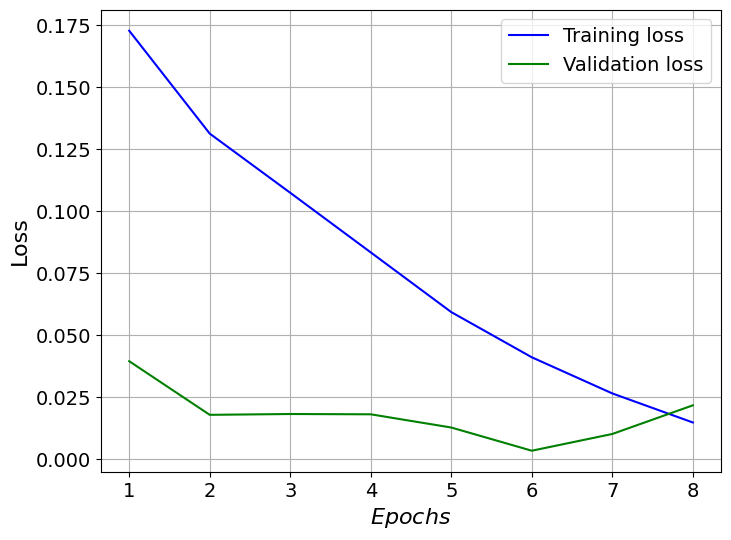

In [6]:
fn.PlotLossAcc(TrainData=LossFine, ValData=ValLossFine, Epochs=EpochsFine,
            TrainLabel='Training loss', ValLabel='Validation loss',
            yLabel='Loss', title='Training and validation recall fine-tuning of the entire model Xception',
            ColTrain='blue', ColVal='green', filename="../images/recall_fine.pdf")

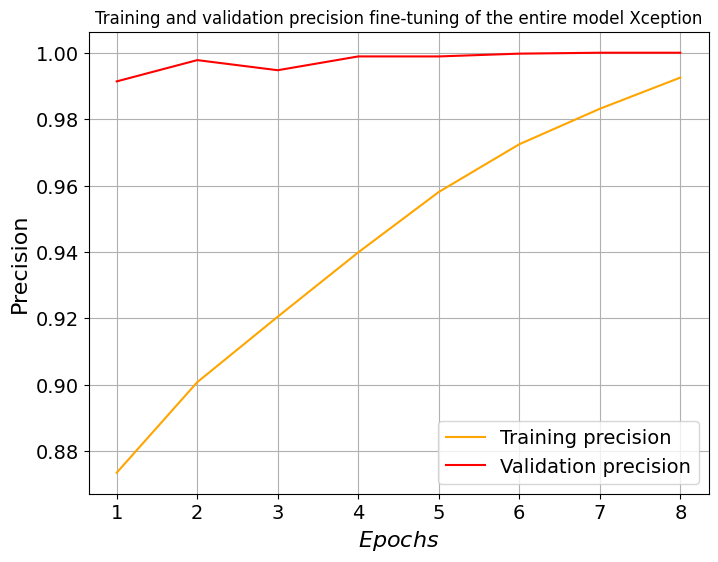

In [45]:
fn.PlotLossAcc(TrainData=AccFine, ValData=VallAccFine, Epochs=EpochsFine,
            TrainLabel='Training precision', ValLabel='Validation precision',
            yLabel='Precision', title='Training and validation precision fine-tuning of the entire model Xception',
            ColTrain='orange', ColVal='red', filename="../images/precision_fine.pdf")

Let's test Xception on the another dataset of the [article](https://arxiv.org/abs/2001.09127)

The main idea - can the Xception generalise the training data and achieve high performance on a dataset whose data is different from the training data?

In [3]:
audio_folder = '../article/wav_audios/'
output_folder = '../article/article_images'

# fn.create_new_images(audio_folder, output_folder)

In [4]:
csv_file = '../../article/name_labels.csv'
image_folder = '../../article/article_images/'

article_test, article_labels = fn.create_article_dataset(csv_file, image_folder, image_size=(255, 255))

# Define batch size
batch_size = 64

article_test = article_test.shuffle(512, seed=42)
# article_test = article_test.batch(batch_size)
article_test = article_test.prefetch(im.tf.data.experimental.AUTOTUNE)

(255, 255, 3)


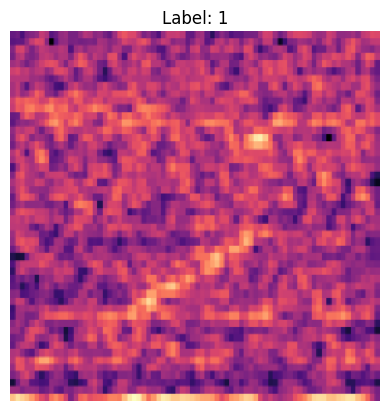

In [7]:
fn.PlotArticleExample(article_test, num=1)

In [123]:
score_x = xception.evaluate(article_test, verbose=0)
print("Xception test loss:", score_x[0])
print("Xception test accuracy:", score_x[1])
print("Xception test Recall:", score_x[2])
print("Xception test Precision:", score_x[3])
print("Xception test F1-score:", 2 * score_x[2] * score_x[3] / (score_x[2] + score_x[3]))

Xception test loss: 0.7772318124771118
Xception test accuracy: 0.6864111423492432
Xception test Recall: 0.8848735094070435
Xception test Precision: 0.6666666865348816
Xception test F1-score: 0.7604259200784081
